In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# Read stroke data
file_path = Path("resources/Stroke_dataset.csv")

# Read the stroke data from the CSV file
df_stroke = pd.read_csv(file_path)

# Display the first few rows of the dataset
df_stroke.head()

FileNotFoundError: [Errno 2] No such file or directory: 'resources/Stroke_dataset.csv'

In [ ]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
file_path = "resources/Stroke_dataset.csv"  
df_stroke = pd.read_csv(file_path)

In [ ]:
# Data Preprocessing
# Handle missing values (e.g., impute missing BMI values with the median)
imputer = SimpleImputer(strategy="median")
df_stroke['bmi'] = imputer.fit_transform(df_stroke[['bmi']])


In [ ]:
# Encode categorical columns (e.g., gender, marital status, work type, residence type, smoking status)
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    df_stroke[column] = le.fit_transform(df_stroke[column])
    label_encoders[column] = le

In [ ]:
# Split the dataset into features (X) and target (y)
X = df_stroke.drop(columns=['id', 'stroke'])  # Features
y = df_stroke['stroke']  # Target variable

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Standardize features to bring them to the same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE: stroke
0    3901
1    3901
Name: count, dtype: int64


In [ ]:
# 2. Train Naive Bayes model on the balanced dataset
model = GaussianNB()
model.fit(X_train_smote, y_train_smote)

GaussianNB()

In [ ]:
# 3. Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)

In [ ]:
# 4. Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Accuracy: {accuracy * 100:.2f}%")

Initial Accuracy: 72.11%


In [ ]:
# 5. Generate classification report (precision, recall, F1-score)
print("Initial Classification Report:")
print(classification_report(y_test, y_pred))

Initial Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       960
           1       0.15      0.76      0.25        62

    accuracy                           0.72      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.93      0.72      0.79      1022



In [ ]:
# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Initial Confusion Matrix:")
print(conf_matrix)

Initial Confusion Matrix:
[[690 270]
 [ 15  47]]


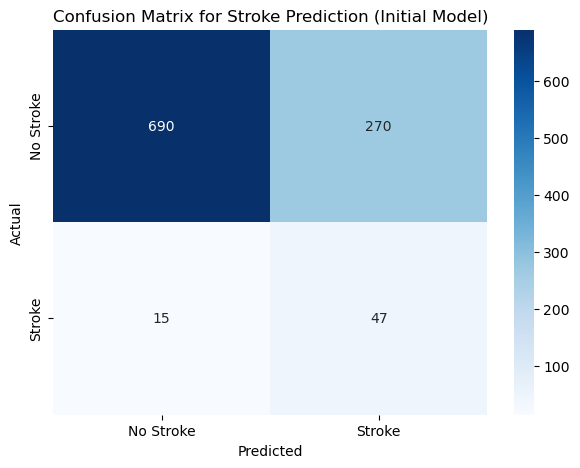

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stroke Prediction (Initial Model)')
plt.show()

In [ ]:
# 7. Hyperparameter Tuning using GridSearchCV (for Naive Bayes)
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters from GridSearchCV: {best_params}")

Best hyperparameters from GridSearchCV: {'var_smoothing': 1e-09}


In [ ]:
# Retrain model with best parameters
optimized_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
optimized_model.fit(X_train_smote, y_train_smote)

# Evaluate the optimized model
y_pred_optimized = optimized_model.predict(X_test_scaled)

In [ ]:
# Optimized Accuracy
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {optimized_accuracy * 100:.2f}%")

Optimized Accuracy: 72.11%


In [ ]:
# Optimized Classification Report
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       960
           1       0.15      0.76      0.25        62

    accuracy                           0.72      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.93      0.72      0.79      1022



In [ ]:
# Optimized Confusion Matrix
optimized_conf_matrix = confusion_matrix(y_test, y_pred_optimized)
print("Optimized Confusion Matrix:")
print(optimized_conf_matrix)

Optimized Confusion Matrix:
[[690 270]
 [ 15  47]]


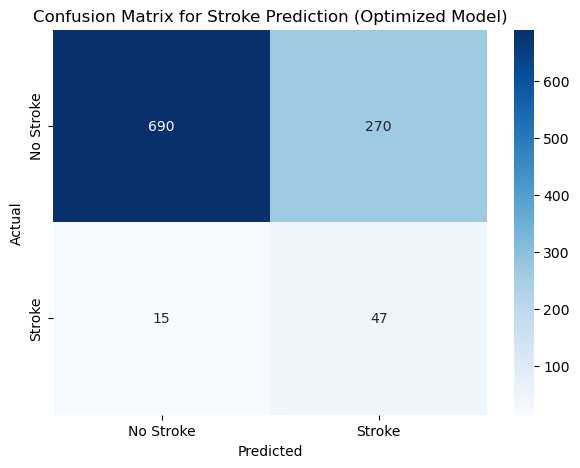

In [ ]:
# Visualize the optimized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(optimized_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stroke Prediction (Optimized Model)')
plt.show()

In [ ]:
# 8. Track Model Performance Across Iterations (Initial, SMOTE, Optimized)
results = {
    'Model': ['Initial', 'Optimized'],
    'Accuracy': [accuracy, optimized_accuracy],
    'Best var_smoothing': [None, best_params['var_smoothing']],
}
results_df = pd.DataFrame(results)

# Save the results to a CSV file for iterative tracking
results_df.to_csv('model_optimization_results.csv', index=False)

# Final Model Performance Output
print("Final Model Performance:")
print(results_df)

Final Model Performance:
       Model  Accuracy  Best var_smoothing
0    Initial  0.721135                 NaN
1  Optimized  0.721135        1.000000e-09


In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Read stroke data
file_path = Path("resources/Stroke_dataset.csv")
df_stroke = pd.read_csv(file_path)

# Data Preprocessing
# Handle missing values (e.g., impute missing BMI values with the median)
imputer = SimpleImputer(strategy="median")
df_stroke['bmi'] = imputer.fit_transform(df_stroke[['bmi']])

# Encode categorical columns (e.g., gender, marital status, work type, residence type, smoking status)
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    df_stroke[column] = le.fit_transform(df_stroke[column])
    label_encoders[column] = le

# Split the dataset into features (X) and target (y)
X = df_stroke.drop(columns=['id', 'stroke'])  # Features
y = df_stroke['stroke']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to bring them to the same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x=y_train, ax=axes[0], palette='Set2')
axes[0].set_title("Class Distribution Before SMOTE")
sns.countplot(x=y_train_smote, ax=axes[1], palette='Set2')
axes[1].set_title("Class Distribution After SMOTE")
plt.show()

# 2. Train Naive Bayes model on the balanced dataset
model = GaussianNB()
model.fit(X_train_smote, y_train_smote)

# 3. Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)

# 4. Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Accuracy: {accuracy * 100:.2f}%")

# 5. Generate classification report (precision, recall, F1-score)
print("Initial Classification Report:")
print(classification_report(y_test, y_pred))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Initial Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix for the initial model
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stroke Prediction (Initial Model)')
plt.show()

# 7. Hyperparameter Tuning using GridSearchCV (for Naive Bayes)
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters from GridSearchCV: {best_params}")

# Retrain model with best parameters
optimized_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
optimized_model.fit(X_train_smote, y_train_smote)

# Evaluate the optimized model
y_pred_optimized = optimized_model.predict(X_test_scaled)

# Optimized Accuracy
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {optimized_accuracy * 100:.2f}%")

# Optimized Classification Report
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Optimized Confusion Matrix
optimized_conf_matrix = confusion_matrix(y_test, y_pred_optimized)
print("Optimized Confusion Matrix:")
print(optimized_conf_matrix)

# Visualize the optimized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(optimized_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stroke Prediction (Optimized Model)')
plt.show()

# 8. Track Model Performance Across Iterations (Initial, SMOTE, Optimized)
results = {
    'Model': ['Initial', 'Optimized'],
    'Accuracy': [accuracy, optimized_accuracy],
    'Best var_smoothing': [None, best_params['var_smoothing']],
}
results_df = pd.DataFrame(results)

# Save the results to a CSV file for iterative tracking
results_df.to_csv('model_optimization_results.csv', index=False)

# Final Model Performance Output
print("Final Model Performance:")
print(results_df)

# Visualization of Model Performance Over Iterations
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='Set1')
plt.title('Model Accuracy Across Iterations')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'resources/Stroke_dataset.csv'